# smaller RNN file
This file is meant to do an example of a Recurrent Neural Network running on a dataset that holds much less information than the other set. This is used to try to locate errors in the other program and perform performance on the overall model. This is a temporary piece of code!

The code below is Written to deal with importing data. Similair to the way it is loaded in the big set except shot and player info are not loaded.

In [1]:
import sqlite3
conn = sqlite3.connect('C:\\Users\ChristopherHaack\Downloads\soccer\database.sqlite')
c = conn.cursor()
def getCInfo(cInfo, team_id, corners):
    '''
    helper function to count how many crosses and corners each team has from an xml format
    '''
    cnt1 = 0
    cnt2 = 0
    #some matches dont have this info.
    try:
        cTree = ET.fromstring(cInfo)
        for elem in cTree:
            #each corner/cross is loaded as a set of elements and right now we only care about quantity
            for item in elem:
                if item.text == str(team_id):
                    cnt1 += 1
                elif (item.text != str(team_id)) and (item.tag == 'team'):
                    cnt2 += 1
    except:
        pass
    if corners:
        cnt1 /= 20.
        cnt2 /= 20.
    else:
        cnt1 /= 50.
        cnt2 /= 50.
    return cnt1, cnt2
def getShotInfo(sInfo, team_id):
    '''
    helper function to count how many shots each team has from an xml format
    '''
    cnt1 = 0
    cnt2 = 0
    #some matches dont have this info.
    try:
        shotTree = ET.fromstring(sInfo)
        for elem in shotTree:
            #each shot is loaded as a set of elements and right now we only care about quantity
            for item in elem:
                if item.text == str(team_id):
                    cnt1 += 1
                elif (item.text != str(team_id)) and (item.tag == 'team'):
                    cnt2 += 1
    except:
        pass
    cnt1 /= 50.
    cnt2 /= 50.
    return cnt1, cnt2

def getPosInfo(pInfo, home):
    '''
    helper function to see posession break down of the game at halftime and at full time
    '''
    vals = [0, 0 ,0 ,0]
    #some matches dont have this info.
    try:
        posTree = ET.fromstring(pInfo)

        for elem in posTree:
            for item in elem:
                if item.tag == 'elapsed' and item.text == '90':
                    for i2 in elem:
                        if i2.tag == 'homepos' and home:
                            vals[2] = int(i2.text)/100.
                        elif i2.tag == 'homepos':
                            vals[3] = int(i2.text)/100.
                        elif i2.tag == 'awaypos' and home == False:
                            vals[2] = int(i2.text)/100.
                        elif i2.tag == 'awaypos' and home:
                            vals[3] = int(i2.text)/100.
                elif item.tag == 'elapsed' and item.text == '45':
                    for i2 in elem:
                        if i2.tag == 'homepos' and home:
                            vals[0] = int(i2.text)/100.
                        elif i2.tag == 'homepos':
                            vals[1] = int(i2.text)/100.
                        elif i2.tag == 'awaypos' and home == False:
                            vals[0] = int(i2.text)/100.
                        elif i2.tag == 'awaypos' and home:
                            vals[1] = int(i2.text)/100.
    except:
        pass
    return vals
 


def bookieProb(game):
    hpreds = []
    dpreds = []
    apreds = []
    preds = game[len(game) - 30:]
    for i in range(int(len(preds)/3)):
        hPred = -1
        aPred = -1
        dPred = -1
        if type(preds[i * 3]) == type(1.0) or type(preds[i *3]) == type(1):
            hPred = 1. / preds[i * 3]
            dPred = 1. / preds[i * 3 + 1]
            aPred = 1. / preds[i * 3 + 2]
        hpreds.append(hPred)
        apreds.append(aPred)
        dpreds.append(dPred)
    apreds = list(filter(lambda a: a != -1, apreds)) 
    hpreds = list(filter(lambda a: a != -1, hpreds))
    dpreds = list(filter(lambda a: a != -1, dpreds))
    try:
        awayp = (sum(apreds) / len(apreds))
        homep = (sum(hpreds) / len(hpreds))
        drawp = (sum(dpreds) / len(dpreds))
    except:
        awayp = -1
        homep = -1
        drawp = -1
    pvals = [homep, awayp, drawp]
    return [homep, drawp, awayp, chooseRes(pvals)]
def chooseRes(pred):
    res = pred.index(max(pred))
    if res == 0:
        return 3
    elif res == 1:
        return 0
    else:
        return 1

def gamesMapping(team_id, games, normalize=False):
    ''' this is a helperfunction that returns performance information for different games
    @param team_id is the id of the team
    @param games is the matches it played in
    @normalize attempts to normalize data set
    @return a performance which is a set of lists with stats about each game.
    '''
    performance = []
    for game in games:
        p = []
        #adds the stage of the season the game is in 
        p.append(game[4])
        #checks to see if the team is home team and adds result, which is given by [points, goals scored, goals against]
        if game[7] == team_id:
            home = True
            p.append(game[8])
            if game[9] > game[10]:
                p.append(1)
            elif game[9] == game[10]:
                p.append(1/3.)
            else:
                p.append(0)
            p.append(game[9]/10.)
            p.append(game[10]/10.)
        else:
            home = False
            p.append(game[7])
            if game[9] > game[10]:
                p.append(0)
            elif game[9] == game[10]:
                p.append(1/3.)
            else:
                p.append(1)
            p.append(game[10]/10.)
            p.append(game[9]/10.)
        sinfo = getShotInfo(game[78], team_id)
        p += sinfo
        p += getShotInfo(game[79], team_id)
        p += getCInfo(game[82], team_id, False)
        p += getCInfo(game[83], team_id, True)
        p += getPosInfo(game[84], home)            
        performance.append(p)
    return performance
''' this is the class that will hold all the data'''
class soccerInfo:
    def __init__(self):
        self.seasonData = self.generateSeason()
    def generateSeason(self):
        sVals = []
        for i in range(2008, 2016):
            s = str(i) + "/" + str(i + 1)
            sTemp = season(season = s)
            sVals.append(sTemp)
        return sVals
class season:
    ''' this is a class which will hold performances over a set of seasons'''
    def __init__(self, season = '2015/2016'):
        selectS = ''' select league_id from match '''
        whereS = ''' where season = ''' +  "\"" + season + "\"" 
        grouping = '''
         group by league_id
        having count(*) > 100'''
        statement = selectS + whereS + grouping
        c.execute(statement)
        leagues = c.fetchall()
        self.leagues = leagues
        self.season = season
        self.pVals = self.genInfo()
    def genInfo(self):
        pVals = []
        print(self.season)
        
        for lTemp in self.leagues:
            league = lTemp[0]
            
            try:
                l = leagueSeason(league_id = league, season = self.season)
                pVals.append(l)
            except:
                pass
        return pVals
class leagueSeason:
    ''' this class will hold the information of a given leagues season'''
    def __init__(self, league_id = 1729, season = '2015/2016'):
        statement = '''select home_team_api_id
    from match where'''
        
        league_clause = " league_id = " + str(league_id)
        s_clause = " season = " +  "\"" + season + "\"" 
        o_clause = " group by home_team_api_id"
        statement += league_clause + " and " + s_clause + o_clause
        c.execute(statement)
        teams = c.fetchall()
        teams1 = []
        for team in teams:
            teams1.append(team[0])
        self.teams = teams1
        self.league_id = league_id
        self.season = season
        self.info =self.getSeasonInfo()
        self.binfo = self.getBookieInfo()
        self.performances = self.generateSeasonPerformance()
    def getBookieInfo(self):
        ''' class that is used to determine y values, basically just gives
        the two teams playing the game and the result and the stage of the season'''
        statement = '''select *
        from match where'''
        league_clause = " league_id = " + str(self.league_id)
        s_clause = " season = " +  "\"" + self.season + "\"" 
        o_clause = " order by stage"

        statement += league_clause + " and " + s_clause + o_clause
        c.execute(statement)
        gameInfo = c.fetchall()
        gameInfo1 = []
        for game in gameInfo:
            g = []
            g.append(game[4])
            g.append(game[7])
            g.append(game[8])
            g.append(game[9])
            g.append(game[10])
            if game[9] > game[10]:
                g.append(3)
            elif game[10] > game[9]:
                g.append(0)
            else:
                g.append(1)
            bookie = bookieProb(game)
            for item in bookie:
                g.append(item)
            gameInfo1.append(g)
        return gameInfo1   
    #this is a helper function used to get all of the team performance information
    def generateSeasonPerformance(self):
        performances = []
        for team in self.teams:
            p = teamPerformance(team, self.season)
            performances.append(p)
        return performances
    def getSeasonInfo(self):
        ''' class that is used to determine y values, basically just gives
        the two teams playing the game and the result and the stage of the season'''
        statement = '''select stage,
        home_team_api_id,
        away_team_api_id, 
        home_team_goal, 
        away_team_goal
        from match where'''
        league_clause = " league_id = " + str(self.league_id)
        s_clause = " season = " +  "\"" + self.season + "\"" 
        o_clause = " order by stage"

        statement += league_clause + " and " + s_clause + o_clause
        c.execute(statement)
        gameInfo = c.fetchall()
        gameInfo1 = []
        for game in gameInfo:
            g = []
            for i in game:
                g.append(i)
            if game[4] < game[3]:
                g.append(3)
            elif game[4] > game[3]:
                g.append(0)
            else:
                g.append(1)
            gameInfo1.append(g)
        return gameInfo1
class teamPerformance:
    
    def __init__(self, team_id = 10260, season = '2015/2016'):
        self.team_id = team_id
        conn = sqlite3.connect('C:\\Users\ChristopherHaack\Downloads\soccer\database.sqlite')
        c = conn.cursor()
        statement =    '''select *
        from match where'''
        h_clause = "home_team_api_id = " +str(team_id)
        a_clause = "away_team_api_id = " +str(team_id)
        o_clause = " order by stage"
        s_clause = " season = " +  "\"" + season + "\"" 
        statement +=  s_clause + 'and ( ' + h_clause + ' or ' + a_clause +' ) ' + o_clause
        c.execute(statement)
        games = c.fetchall()
        self.team_id = team_id
        performance = gamesMapping(self.team_id, games)
        self.performance = performance

### loading of information

In [2]:
c = soccerInfo()


2008/2009
2009/2010
2010/2011
2011/2012
2012/2013
2013/2014
2014/2015
2015/2016


# Converting loaded data to X and Y

## also includes making timestep versions and getting opposition pergame stats


### also creates one hot vector for y values

This is the part of code that is responsible for converting loaded data into game information. The idea behind this is now we convert an x as a vector of the 5 previous games such that we can determine what the previous inputs were during the season. This allows us to have some information. Note that we don't make predictions on the first 5 games of the season because we don't have enough info on the prior games.

In [9]:
vLen = 36
def timeStepX(x):
    xRet = []
    for xt in x:
        xTemp = []
        for i in range(5):
            h = xt[i * vLen: (i +1) * vLen]
            a = xt[(i+5) * vLen: (i + 6) * vLen]
            val = h + a
            xTemp.append(val)
        xRet.append(xTemp)
    return xRet
def resVal(y):
    yVals = []
    for val in y:
        if val[0] == 1:
            yVals.append(3)
        elif val[1] == 1:
            yVals.append(1)
        else:
            yVals.append(0)
    return yVals

#changes the output of a game to a one hot encoding [win, tie, loss]
def resOneHot(y):
    if y == 3:
        return [1 , 0, 0]
    elif y == 1:
        return [0, 1, 0]
    else:
        return [0, 0, 1]
#gives info on how a team does every game and allows us to average the number of points and goals against/scored
def createPerGameMetric(sInfo):
    stats = dict()
    for game in sInfo:
        stage = game[0]
        home = game[1]
        away = game[2]
        hGoals = game[3]
        aGoals = game[4]
        res = game[5]
        if res == 1:
            ires = 1
        else:
            ires = 3 - res
        if stage == 1:
            stats[(stage, home)] = [hGoals, aGoals, res]
            stats[(stage, away)] = [aGoals, hGoals, ires]
        if stage != 1:
            try:
                stats[(stage, home)] = [(hGoals + stats[(stage-1, home)][0]), 
                                        aGoals + stats[(stage-1, home)][1], res + stats[(stage-1, home)][2]]
            except: 
                for i in range(1, 5):
                    if (stage-i, home) in stats:
                        stats[(stage, home)] = [(hGoals + stats[(stage-i, home)][0]),
                                                aGoals + stats[(stage-i, home)][1], res + stats[(stage-i, home)][2]]
                        break;
                    if stage - i < 1:    
                        stats[(stage, home)] = [hGoals, aGoals, res]
                        break;
            try:
                stats[(stage, away)] = [aGoals + stats[(stage-1, away)][1], 
                                        (hGoals + stats[(stage-1, away)][0]), ires + stats[(stage-1, away)][2]]
            except:
                for i in range(1, 5):
                    if (stage-i, away) in stats:
                        stats[(stage, away)] = [aGoals + stats[(stage-i, away)][1],
                                                (hGoals + stats[(stage-i, away)][0]), ires + stats[(stage-i, away)][2]]
                        break;
                    if stage - i < 1:
                        stats[(stage, away)] = [aGoals, hGoals, ires]
                        break;
                        
    return stats    


#creates a flat version of the x as a 1 x 8240 matrix and the y's as one hot vectors.
def createDataSet2(gameInfo, season):
    
    ''' code used to create x and y values from a given season and set of games
    creates a y value that is listed as a one hot vector
     and x as a 1 x 8240 matrix that give information about the past 5 games'''
    x = []
    y = []
    cnt = 0
    teamDic = dict()
    teams = season.teams
    #this code block is meant to fix a mistake in the definition of my data structure, should really make performances
    # a dictionary which each team name as a key, and the performances as a val.
    gameMetric = createPerGameMetric(season.info)
    for team in teams:
        teamDic[team] = cnt
        cnt += 1
    for game in gameInfo:
        example = []
        stage = game[0]
        res = game[5]
        #the result of the game will constitute our y set. 0 = home loss, 1 = home draw, 3 = home win.
        y.append(resOneHot(res))
        home = game[1]
        away = game[2]
        homeLoc = teamDic[home]
        awayLoc = teamDic[away]
        #a training example will be a 10 * 824, with the home teams most recent 5 games as the first 5 values
        #followed by the away teams most recent 5 games.
        for i in range((stage-6), (stage-1)):
            game = season.performances[homeLoc].performance[i]
            #first two items in game are the stage and away team api Id which I don't use in this
            # model
            s = i + 1
            if (s, game[1]) in gameMetric:
                oppStats = gameMetric[(s, game[1])]
            else:
                oppStats = gameMetric[(s + 1, game[1])]
            if (s, home) in gameMetric:
                hStats = gameMetric[(s, home)]
            else:
                hStats = gameMetric[(s + 1 , home)]
            game1 = game[2:]
            for d in game1:
                example.append(d)
            for z in oppStats:
                example.append(z/s)
        for j in range((stage-6), (stage-1)):
            s = j + 1
            game = season.performances[awayLoc].performance[j]
            if (s, game[1]) in gameMetric:
                oppStats = gameMetric[(s, game[1])]
            else:
                oppStats = gameMetric[(s + 1, game[1])]
            if (j, away) in gameMetric:
                aStats = gameMetric[(s, away)]
            else:
                aStats = gameMetric[(s + 1 , away)]
            game1 = game[2:]
            for d in game1:
                example.append(d)
            for z in oppStats:
                example.append(z/s)
        x.append(example)
    return x, y
def tieVal(yVals):
    ys = []
    for y in yVals:
        if y[0] == 1:
            ys.append(1)
        else:
            ys.append(0)
    return ys
def generateSets(seasons):
    trainX = []
    trainY = []
    testX = []
    testY = []
    for i in range(6):
        for k in range(10):
            season1 = seasons.seasonData[i].pVals[k]
            numTeams = len(season1.teams)
            n = int(numTeams / 2 *  5)
            t = season1.info[n:]
            try:
                x ,y = createDataSet2(t, season1)
                trainX = trainX + x
                trainY = trainY + y
            except:
                pass
                
    for j in range(2):
        for k in range(10):
            season1 = seasons.seasonData[j + 6].pVals[k]
            numTeams = len(season1.teams)
            n = int(numTeams / 2 *  5)
            t = season1.info[n:]
            try:
                x ,y = createDataSet2(t, season1)
                testX = testX + x
                testY = testY + y
                
            except: 
                pass
    tieTrainY = toTie(trainY)
    tieTestY = toTie(testY)
    return trainX, trainY, testX, testY, tieTrainY, tieTestY
def toTie(yVals):
    tieY = []
    for y in yVals:
        if y[1] == 1:
            tieY.append([1, 0])
        else:
            tieY.append([0, 1])
    return tieY
def filterX(tx):
    xRet = []
    for x in tx:
        xTemp = []
        for i in x:
            if type(i) != type(1) and type(i) != type(1.):
                xTemp.append(0)
            else:
                xTemp.append(i)
        xRet.append(xTemp)
    return xRet

In [13]:
trainX, trainY, testX, testY, tieTrainY, tieTestY = generateSets(c)
print(len(trainX),  len(trainY), len(tieTrainY), len(trainX[1]))
print(len(testX),  len(testY))


15326 15326 15326 180
5401 5401
0.7467135715608221


# Random Forest Classification

This is a random forst model that is used to classify soccer games. It is meant as a bench mark to compare the RNN model to. Our hope is that the RNN performs better than this. currently on this stratified set it performs at roughly 47%

In [10]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
trainY2 = resVal(trainY)
testY2 = resVal(testY)
ttrainY2 = tieVal(tieTrainY)
ttestY2 = tieVal(tieTestY)
clf = RandomForestClassifier(n_estimators= 250)
clf.fit(trainX, trainY2)
print(clf.score(trainX, trainY2))
print(clf.score(testX, testY2))

yRF = clf.predict(testX)


clf.fit(trainX, ttrainY2)
print(clf.score(trainX, ttrainY2))
print(clf.score(testX, ttestY2))


1.0
0.47065358267
1.0
0.746713571561


# RNN MODEL

this is the part of the code that trains a lstm rnn model on the simple data set above. It takes input as a time sequence
which is a 5 X 12 vector denoting 12 stats for the previous 5 games, the home team result goals scored and goals against, and strength of the oppsotion, and similiarly the away teams result goals scored and goals against and strength of opposition. 
It then has to 512 X 512 nodes in which it learns features and dependencies and finaly this is brought together in a 3 softmax classificaiton. 

In [14]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(5, 36)))
model.add(Dropout(0.5))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

trainX1 = timeStepX(trainX)
testX1 = timeStepX(testX)
for iteration in range(1, 50):
    print
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(trainX1, trainY, batch_size=1024, nb_epoch=1)


Using TensorFlow backend.


--------------------------------------------------
Iteration 1
Epoch 1/1
15326/15326 [==============================] - 5s - loss: 1.2152     
--------------------------------------------------
Iteration 2
Epoch 1/1
15326/15326 [==============================] - 2s - loss: 1.0616     
--------------------------------------------------
Iteration 3
Epoch 1/1
15326/15326 [==============================] - 2s - loss: 1.0534     
--------------------------------------------------
Iteration 4
Epoch 1/1
15326/15326 [==============================] - 2s - loss: 1.0509     
--------------------------------------------------
Iteration 5
Epoch 1/1
15326/15326 [==============================] - 2s - loss: 1.0408     
--------------------------------------------------
Iteration 6
Epoch 1/1
15326/15326 [==============================] - 2s - loss: 1.0390     
--------------------------------------------------
Iteration 7
Epoch 1/1
15326/15326 [==============================] - 2s - loss: 1.0382     

## RNN Test Performance

this is the code that checks how well the RNN did on the test set

In [15]:
yVals = model.predict_on_batch(testX1)
s4 = 0
for i in range(len(yVals)):
    y = yVals[i]
    y = list(y)
    idx = y.index(max(y))
    if testY[i][idx] == 1:
        s4 += 1
print(s4/len(yVals))

0.48102203295685986


# Test RNN Info

this code gives more of a breakdown into the test performance of the RNN model it checks to make sure it is not just guessing that the home team wins, and testing what the naive strategy of guessing the home team wins every game would yield.

In [14]:
cntAway = 0
cntTie = 0
for pred in yVals:
    if pred[0] < pred[2]:
        cntAway +=1
    elif pred[0] < pred[1]:
        cntTie += 1
print(cntAway, cntTie)

perHW = 0
for p in testY:
    if p[0] == 1:
        perHW +=1
perHW /= len(testY)
print(perHW)

1229 36
0.4473245695241622


# insample performance of RNN

this is the code used to check the in sample (training) performance of the Recurrent Neural Network, high training performance means overfitting.


In [15]:
yt = model.predict(trainX1, batch_size = 32) 
s4 =0
for i in range(len(yt)):
    y1 = yt[i]
    y1 = list(y1)
    idx = y1.index(max(y1))
    if trainY[i][idx] == 1:
        s4 += 1
print(s4/len(yt))

0.5048283961894819


# Confusion Matrix and Understanding data

this is my first attempt at creating some kind of metrics to better understand the performance of the neural network. I will be checking the confusion matrix which is denoted as following first column/row is losses, second is tie, third is wins. 
columns denote predictions, row denote truths, i.e. (the location 0, 2 first row third column means it was a home loss and the network predicted a home win) 

we will also compute recall and precision, and f1 to get a better understanding of how this network works. 

Furthermore nice plots/visuals may be added here as well to make it a little less of an eye sore. 

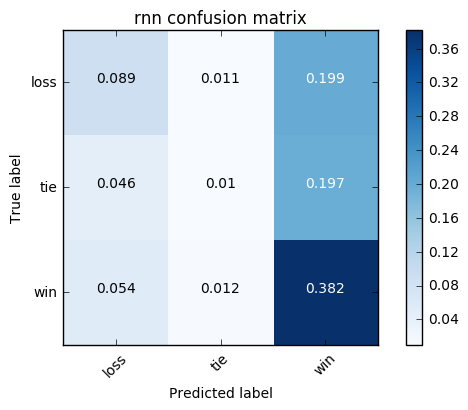

confusion matrix
[[ 0.089  0.011  0.199]
 [ 0.046  0.01   0.197]
 [ 0.054  0.012  0.382]]

precision
[0.47089947089947087, 0.30303030303030304, 0.49100257069408737]

recall
[0.2976588628762542, 0.039525691699604744, 0.8526785714285714]

f1score
[0.36475409836065575, 0.069930069930069935, 0.62316476345840133]


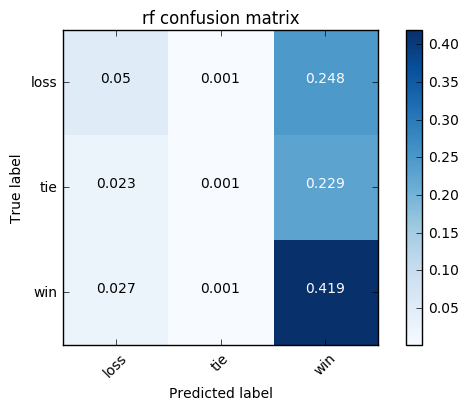

confusion matrix
[[ 0.05   0.001  0.248]
 [ 0.023  0.001  0.229]
 [ 0.027  0.001  0.419]]

precision
[0.5, 0.33333333333333331, 0.4676339285714286]

recall
[0.16722408026755856, 0.003952569169960474, 0.93736017897091717]

f1score
[0.25062656641604014, 0.0078125, 0.6239761727475801]


In [19]:
from sklearn.metrics import confusion_matrix

import itertools
import matplotlib.pyplot as plt
def convertPreds(yVals):
    y_pred = []

    for i in range(len(yVals)):
        y = yVals[i]
        y = list(y)
        idx = y.index(max(y))
        if idx == 0:
            y_pred.append(3)
        elif idx == 1:
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

y_pred = convertPreds(yVals)
    
a = confusion_matrix(testY2, y_pred)
a = np.divide(a, len(testY2))
b = confusion_matrix(testY2, yRF)
b = np.divide(b, len(testY2))

def recall(a):
    pVec = []
    for i in range(len(a)):
        tP = a[i][i]
        tot = sum(a[i])
        pVec.append(tP/tot)
    return pVec
def precision(a):
    rVec = []
    for i in range(len(a)):
        tP = a[i][i]
        tot = 0
        for j in range(len(a)):
            tot += a[j][i]
        rVec.append(tP/tot)
    return rVec

def f1(p, r):
    f1Vec = []
    for i in range(len(r)):
        n = 2 * p[i] * r[i]
        d = p[i] + r[i] 
        f1Vec.append(n/d)
    return f1Vec

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = np.round(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    p = precision(cm)
    r = recall(cm)
    f1Score = f1(p, r)



    print("confusion matrix")
    print(cm)
    print()

    print("precision")
    print(p)

    print()
    print("recall")
    print(r)

    print()
    print("f1score")
    print(f1Score)

plot_confusion_matrix(a, ['loss', 'tie', 'win'], title = 'rnn confusion matrix')

plot_confusion_matrix(b, ['loss', 'tie', 'win'], title = 'rf confusion matrix')



# bookie predictions given in the data set.

this is code to compare bookie prediction given in the dataset

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt
def accuracy(true, pred):
    s = 0
    for i in range(len(true)):
        if true[i] == pred[i]:
            s += 1
    return(s/len(pred))
def generateConfMatrix(seasons):
    bookies = []
    actual = []
    for i in range(2):
        for k in range(10):
            season1 = seasons.seasonData[i + 6].pVals[k]
            numTeams = len(season1.teams)
            n = int(numTeams / 2 *  5)
            t = season1.binfo[n:]
            t1 = season1.info[n:]
            try:
                x ,y = createDataSet2(t1, season1)
                b = [i[9] for i in t]
                a = [i[5] for i in t]
                for item in b:
                    bookies.append(item)
                for item in a:
                    actual.append(item)
            except:
                pass
            
    print(accuracy(actual, bookies))
    print(len(actual))
    c = confusion_matrix(actual, bookies) 
    c = np.divide(c, len(bookies))
    plot_confusion_matrix(c, ['loss', 'tie', 'win'], title = 'bookie confusion matrix')
   

0.5223106832068135
5401


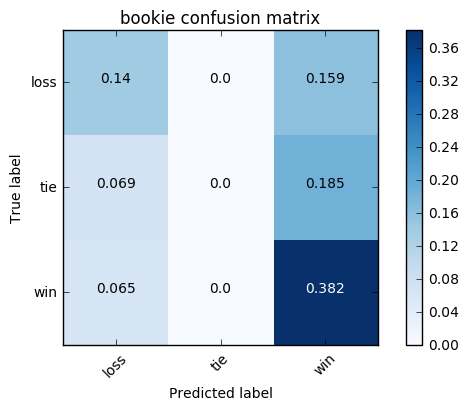

confusion matrix
[[ 0.14   0.     0.159]
 [ 0.069  0.     0.185]
 [ 0.065  0.     0.382]]

precision
[0.51094890510948909, nan, 0.52617079889807161]

recall
[0.46822742474916385, 0.0, 0.85458612975391501]

f1score
[0.48865619546247824, nan, 0.6513213981244671]


C:\Users\ChristopherHaack\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: RuntimeWarning: invalid value encountered in double_scalars


In [18]:
generateConfMatrix(c)

# Ein vs Eout
this is where i compare ein and eout as a function of the number of epochs i train the model


In [19]:



def trainLSTM(n_epochs):
    if 'session' in locals() and session is not None:
        print('Close interactive session')
        session.close()

    from keras.models import Sequential
    from keras.layers.core import Dense, Activation, Dropout
    from keras.layers.recurrent import LSTM
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(5, 36)))
    model.add(Dropout(0.5))
    model.add(LSTM(512, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(3))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    trainX1 = timeStepX(trainX)
    testX1 = timeStepX(testX)
    model.fit(trainX1, trainY, verbose = 0, batch_size=1024, nb_epoch=n_epochs)
    yVals = model.predict_on_batch(testX1)
    s4 = 0
    for i in range(len(yVals)):
        y = yVals[i]
        y = list(y)
        idx = y.index(max(y))
        if testY[i][idx] == 1:
            s4 += 1
    testErr = 1 - (s4/len(yVals))
    yt = model.predict(trainX1, batch_size = 32) 
    s3 =0
    for i in range(len(yt)):
        y1 = yt[i]
        y1 = list(y1)
        idx = y1.index(max(y1))
        if trainY[i][idx] == 1:
            s3 += 1
    trainErr = 1 - (s3/len(yt))
    return(trainErr, testErr)
def runModels():
    num_epochs = list(range(10, 101, 10))
    train = []
    test = []
    for n in num_epochs:
        print(n)
        errs = trainLSTM(n)
        train.append(errs[0])
        test.append(errs[1])
    plt.plot(num_epochs, train, '-', label='training error')
    plt.plot(num_epochs, test, '-', label='test error')
    plt.xlabel('number of epochs')
    plt.ylabel('error rates in % error')
    plt.legend()
    plt.show()

10
20
30
40
50
60
70
80
90
100


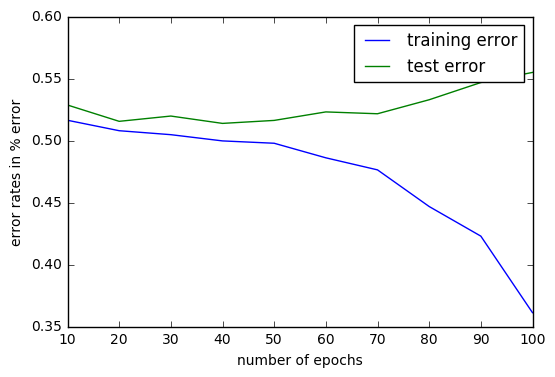

In [20]:
runModels()

In [16]:
def genBookies(seasons):
    bookies = []
    actual = []
    for i in range(2):
        for k in range(10):
            season1 = seasons.seasonData[i + 6].pVals[k]
            numTeams = len(season1.teams)
            n = int(numTeams / 2 *  5)
            t = season1.binfo[n:]
            t1 = season1.info[n:]
            try:
                x ,y = createDataSet2(t1, season1)
                b = [i[6:] for i in t]
                a = [i[5] for i in t]
                for item in b:
                    bookies.append(item)
                for item in a:
                    actual.append(item)
            except:
                pass
    return bookies, actual
bookiePreds, actual = genBookies(c)
    

# Betting Simulations

the following codes below provide indepth betting simulations based on an amount of starting capital and predictions given by bookies, ourmodel, and the actual results of those games. It keeps track of the total amount of cash we have over a set of time given some sort of betting strategy.

In [20]:
startCash = 10000
betLimit = 100
def bet(cash, bookiePred, ourRes, ourPred, res, betLimit):
    ''' this is a naive strategy where we only bet on games that were more confident of our prediction'''
    bookieRes = bookiePred[3]
    newCash = cash
    bPred = bookiePred[:3]
    right = 0
    if bookiePred[0] != -1:
        if bookieRes == ourRes and max(bPred) < max(ourPred):
            bAmount = betLimit * (max(ourPred) - max(bPred))
            ourBet = ourRes
            newCash = cash - bAmount
            if ourBet == res:
                newCash = newCash + (bAmount * 1/(max(bPred)))
                right = 1
            else:
                right = -1
    return newCash, right
def betSimulator(startCash, betLimit, bookie, preds, results):
    cashAmounts = []
    n = len(bookie)
    time = list(range(n))
    ourResults = convertPreds(preds)
    cash = startCash
    n_right = 0
    n_wrong = 0
    for i in range(n):
        ourPred = preds[i]
        ourRes = ourResults[i]
        bookiePred = bookie[i]
        res = results[i]
        cash, right = bet(cash, bookiePred, ourRes, ourPred, res, betLimit)
        if right == 1:
            n_right += 1
        elif right == -1:
            n_wrong += 1
        cashAmounts.append(cash)
    print(n_right, n_wrong)
    plt.plot(time, cashAmounts, '-', label='cash')
    plt.xlabel('number of games')
    plt.ylabel('amount of cash')
    plt.show()
    

539 682


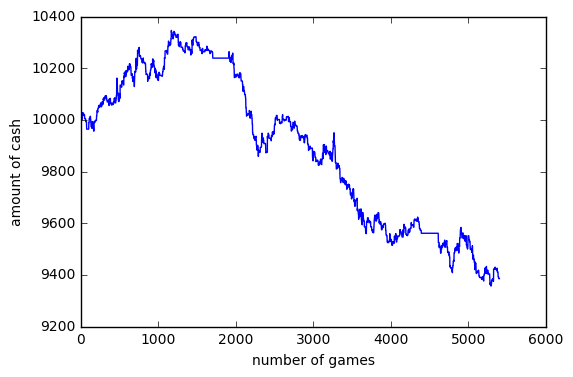

In [21]:

betSimulator(startCash, betLimit, bookiePreds, yVals, actual)

# Learning Betting Models
this is my first attempt at using ML techniques to learn new betting models. The idea was very simple, lets bet based on the difference between my bet and the bookies, and scale whether it is a win, tie or loss based on the corresponding profit that I would recieve. This learning algorithm used Stochastic Gradient Descent on half of the test set, and then saw how well the bets did on the other half of the test set. This model seems to be profitable, but I always view profits with extreme caution and will double check this again.

In [175]:
import random
#assume that we expect to make no more than 500 on a bet or 5 x return on our bet limit
maxEarnings = 5 * betLimit


def L(bet, res, amount, odds):
    '''L will be the loss function based on a given bet. the idea is we will train the amount to bet given the odds
    that are given to us and our probability'''
    profit = 0
    profit -= amount
    if bet == res:
        profit += amount * 1/odds
    ''' note there will be loss even when we dont place a bet, this should be fine'''
    loss = ((maxEarnings - profit) ** 2)/40000
    return loss

def grad(correct, amount, odds):
    ''' gradient of the loss function'''
    p = (correct * 1/odds - 1) * amount
    lG = (p - maxEarnings)/2500
    return lG

def bet2(cash, bookiePred, ourRes, ourPred, res, betLimit, k, b):
    ourPred = ourPred.tolist()
    loc = ourPred.index(max(ourPred))
    kVal = k[loc]
    bPred = bookiePred[:3]
    newCash = cash
    if bookiePred[0] != -1:
        bAmount = betLimit * (max(ourPred) - bPred[loc]) * b * kVal
        ourBet = ourRes
        newCash = newCash - bAmount
        if ourBet == res:
            newCash = newCash + (bAmount * 1/(bPred[loc]))
    return newCash
def betSim(bookie, preds, results, k , b):
    startCash = 10000
    cashAmounts = []
    n = len(bookie)
    time = list(range(n))
    ourResults = convertPreds(preds)
    cash = startCash
    maxDiff = 0
    for i in range(n):
        ourPred = preds[i]
        ourRes = ourResults[i]
        bookiePred = bookie[i]
        res = results[i]
        cash= bet2(cash, bookiePred, ourRes, ourPred, res, betLimit, k , b)
        cashAmounts.append(cash)
        if cashAmounts[i] - cashAmounts[i-1] > maxDiff:
            maxDiff = cashAmounts[i] - cashAmounts[i-1]
    plt.plot(time, cashAmounts, '-', label='cash')
    plt.xlabel('number of games')
    plt.ylabel('amount of cash')
    plt.show()
    print(cashAmounts[n-1], maxDiff)
    
def trainBets(bookie, preds, results):
    #k is the factor by which we decide how much to bet for home win/draw/loss this is one of two factors we will learn
    k = [.01, .01, .01]
    #b is the betting ratio, which will be defined as how strong a bet should be given the confidence of our scores.
    b = 1
    n = len(bookie)
    a = list(range(n))
    random.shuffle(a)
    ourResults = convertPreds(preds)
    epochs = 1000
    learningRate = .001
    for run in range(epochs):
        # update k hold b fixed
        for i in a[:50]:
            ourPred = preds[i]
            ourPred = ourPred.tolist()
            loc = ourPred.index(max(ourPred))
            kVal = k[loc]
            ourRes = ourResults[i]
            bookiePred = bookie[i]
            odds = bookiePred[loc]
            res = results[i]
            correct = (ourRes == res)
            bAmount =  betLimit * (max(ourPred) - bookiePred[loc]) * b * kVal
            kVal = kVal - learningRate * grad(correct, bAmount, odds)
            k[loc] = kVal
    
    return b, k

[8.897428025307887, 0.21033087417275992, 1.8505541786102988]


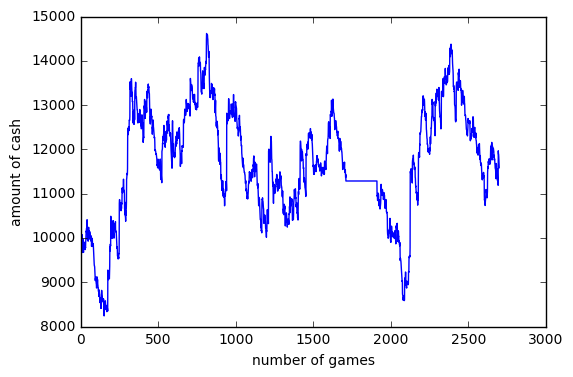

11585.725427241818 1748.743984527502


In [176]:
n = len(actual)
n = int(n/2) + 1
b1, b2 = bookiePreds[:n], bookiePreds[n:]
yVal1, yVal2 = yVals[:n], yVals[n:]
a1, a2 = actual[:n], actual[n:]
b, k = trainBets(b1, yVal1, a1)
print(k)
betSim(b2, yVal2, a2, k, b)